In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', 500)

import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from collections import Counter

import string
import emoji

import pickle

## IMPORTANDO CONVERSACIONES DE WHATSAPP

In [32]:
files_individual = os.listdir('data/WhatsApp_txt/individual')
files_groups = os.listdir('data/WhatsApp_txt/groups')

In [74]:
def read_history(file,conv_type):
    f = open('data/WhatsApp_txt/{}/{}'.format(conv_type,file), 'r',encoding="utf8")
 
    # Aplicamos esta expresión regular para extraer los grupos de patrones en fecha - usuario - mensaje
    messages = re.findall('(\d+\/\d+\/\d+ \d+:\d+) (.*?) - (.*?): (.*)', f.read())
    f.close()

    history = pd.DataFrame(messages,columns =['date','formato_horario','name','msg'])
    history.drop('formato_horario', axis=1, inplace=True)
    history['date'] = history['date'].replace({'a. m.':'am','p. m.':'pm'})
    history['date'] = pd.to_datetime(history['date'],format="%d/%m/%y %I:%M")
    history['date1'] = history['date'].apply(lambda x: x.date())
    history['msg_len'] = history['msg'].str.len()
    history['conv_name'] = file[19:-4]

    return history

In [75]:
all = []
for file in files_individual:
    history = read_history(file,'individual')
    history['tipo'] = 'i'
    all.append(history)

for file in files_groups:
    history = read_history(file,'groups')
    history['tipo'] = 'g'
    all.append(history)

In [77]:
history = pd.concat(all).reset_index()

In [104]:
# Borrando mensales con multimedia y nulos
history['msg'].replace("<Multimedia omitido>","",inplace=True)
history = history[history['msg'] != '']
history_clean = history.sort_values(by=['conv_name','name','date1'])

In [89]:
history_clean.sample(5)

index                date             name  \
1180    1180 2015-04-30 06:20:00               JH   
52205   1154 2019-12-20 04:59:00  Jesús Gutiérrez   
2173    2173 2015-06-08 03:39:00   Danilo Sanchez   
38300   2277 2019-05-25 05:06:00      David Mejía   
40035   1222 2019-09-09 09:35:00  +56 9 7351 0161   

                                                     msg       date1  msg_len  \
1180                                            Es poner  2015-04-30        8   
52205                Ya compré todo muchachos prepárense  2019-12-20       35   
2173                                             Siii :c  2015-06-08        7   
38300                 Ando en la pizza del perro negro 😁  2019-05-25       34   
40035  Aprovecho de preguntar si alguien viaja mañana...  2019-09-09       58   

                         conv_name tipo  
1180              n Danilo Sanchez    i  
52205                n Élite mexas    g  
2173              n Danilo Sanchez    i  
38300     n Alitas _ mamma pack _v    g  
40035  n Madrid Fundacion Carolina    g

### NÚMERO DE CHATS Y NÚMERO DE CONVERSACIONES

In [106]:
history_clean.shape

(54124, 8)

In [107]:
history_clean['year'] = history_clean['date'].dt.year
history_clean['month'] = history_clean['date'].dt.month

# número de mensajes que envío
msg_lai = (history_clean[history_clean['name']=='Lai']
           .sort_values(by=['year','month','conv_name'])
           .groupby(['year','month','conv_name'])['name']
           .count()
           .reset_index())

# número total de mensajes
msg_all = (history_clean
           .sort_values(by=['year','month','conv_name'])
           .groupby(['year','month','conv_name'])
           .agg({'msg': 'count', 'name': pd.Series.nunique})
           .reset_index())

# Promedio de mensajes enviados por persona en una conversación
msg_all['avg_msg'] = msg_all['msg'] / msg_all['name']

participation = msg_all.merge(msg_lai,on=['year','month','conv_name'],how='left').fillna(0)
participation['participation'] = participation['name_y'] / participation['avg_msg']
participation = (participation
                 .sort_values(by=['year','month','conv_name'])
                 .rename(columns={'msg':'total_conv_msg','name_x':'conv_participants','name_y':'total_own_msg'}))

history_clean = (history_clean
                 .sort_values(by=['year','month','conv_name'])
                 .merge(participation, on=['year','month','conv_name'], how='left'))

## Media de mensajes enviados por usuario

In [108]:
msg_all.sort_values('avg_msg', ascending=False).head(3)

year  month         conv_name   msg  name  avg_msg
178  2020      4      n Paloma Mut  1252     2    626.0
122  2019      6      n Yuri Acuña   862     2    431.0
18   2016      1  n Danilo Sanchez   803     2    401.5

In [117]:
history_clean.sample(5)

index                date              name  \
1322    1371 2015-05-13 05:45:00    Danilo Sanchez   
35949   3964 2019-12-09 10:11:00  +34 635 13 64 20   
49408   8276 2020-04-11 09:33:00        Paloma Mut   
39797   3071 2020-01-21 00:40:00    Daniel Sánchez   
48003    654 2020-04-14 00:53:00  Federico Soriano   

                                          msg       date1  msg_len  \
1322                            Si ese vavava  2015-05-13       13   
35949             En la página de la embajada  2019-12-09       27   
49408                     Jajaa me dices jaja  2020-04-11       19   
39797  Pues bueno. Ya tengo prácticas amigos.  2020-01-21       38   
48003                                      Si  2020-04-14        2   

                         conv_name tipo  year  month  total_conv_msg  \
1322              n Danilo Sanchez    i  2015      5             433   
35949  n Madrid Fundacion Carolina    g  2019     12             834   
49408                 n Paloma Mut    i  2020      4            1252   
39797                n Élite mexas    g  2020      1            1394   
48003   n Máster Big Data _ Teleco    g  2020      4            1220   

       conv_participants     avg_msg  total_own_msg  participation  
1322                   2  216.500000            0.0            0.0  
35949                 76   10.973684            0.0            0.0  
49408                  2  626.000000            0.0            0.0  
39797                  7  199.142857            0.0            0.0  
48003                 25   48.800000            0.0            0.0

In [106]:
# # Importing file with category classification for each conversation (manually made)
# # Includes 2 columns: conv_name, category
# with open('categories.pkl', 'rb') as picklefile:
#     categories = pickle.load(picklefile)

In [108]:
# history_clean = history_clean.merge(categories,on='conv_name')

In [118]:
# Exporting history cleaned for processing
with open('history_clean.pkl', 'wb') as picklefile:
    pickle.dump(history_clean, picklefile)

## NÚMERO DE MENSAJES POR AÑO

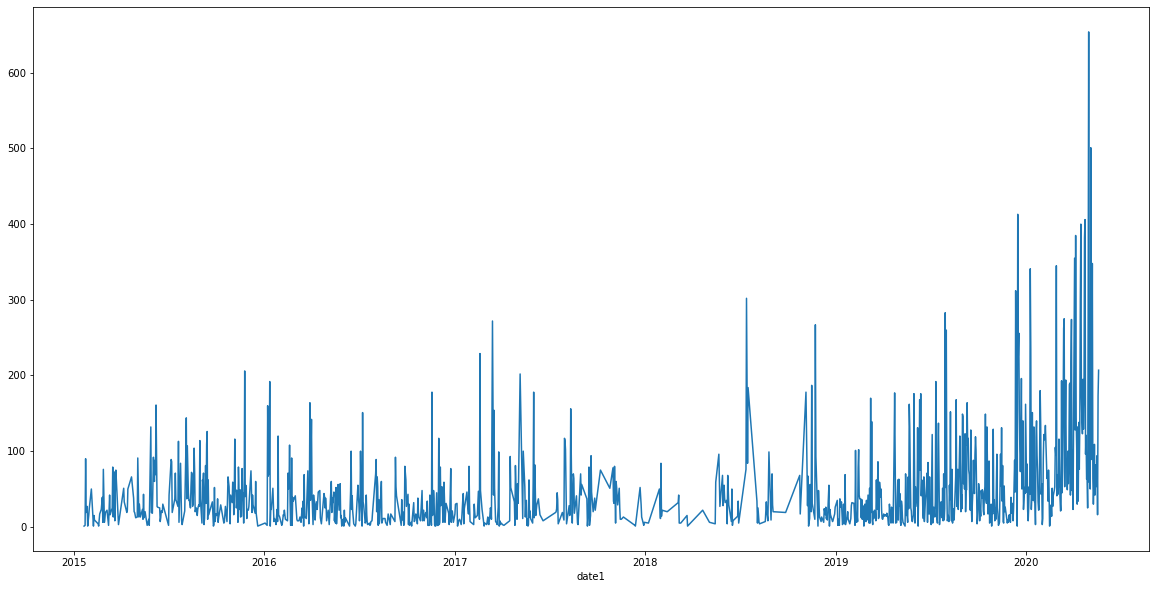

In [119]:
# Number of messages over the years
plt.figure(figsize=(20,10))

history.groupby(['date1']).count()['msg'].plot()

## LONGITUD DE MENSAJES POR AÑO

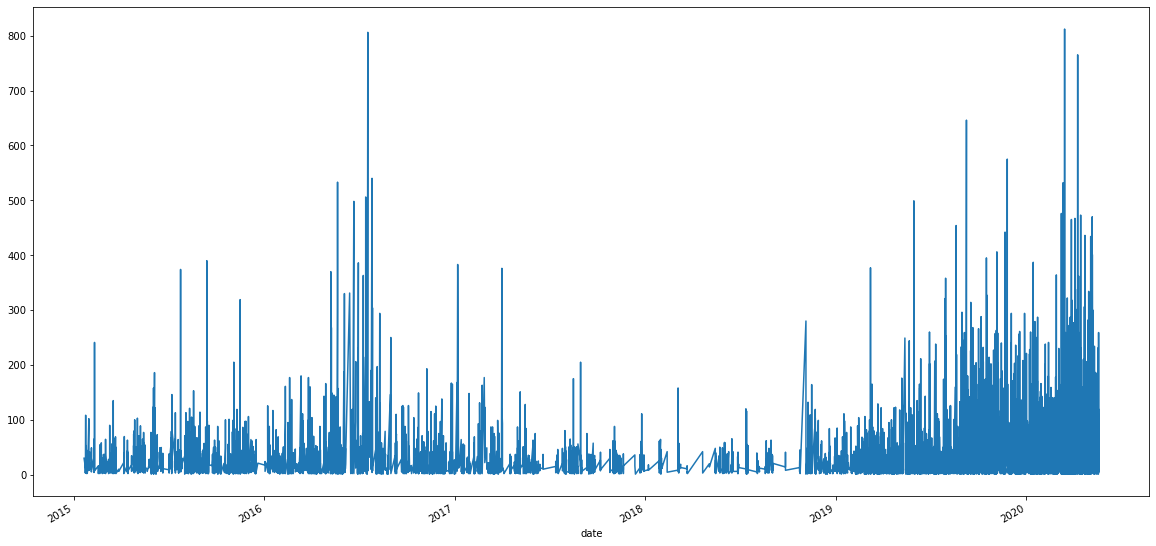

In [120]:
# Length of messages over the years
plt.figure(figsize=(20,10))
history.groupby(['date'])['msg_len'].mean().plot()

## Emojis

In [98]:
# Counting number of emojis
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def Count_Emojis(df):
    series = df['msg']
    all_words = ""
    for sentence in series:
        all_words += extract_emojis(sentence)
    word_count = Counter(all_words)
    
    
    ordered = {}
    ordered['msg'] = []
    for key, number in word_count.most_common()[:50]:
        ordered[key] = []
    
    for sentence in series:
        sentence_count = Counter(extract_emojis(sentence))
        
        for word in ordered:
            count = sentence_count[word] if sentence_count[word] else 0
            ordered[word] += [count]
    ordered['msg'] = list(series)
    ordered['date'] = list(df['date'])
    ordered['date1'] = list(df['date1'])
    ordered['name'] = list(df['name'])
    ordered['conv_name'] = list(df['conv_name'])
    
    return pd.DataFrame(ordered)

In [99]:
# Counting emojis by message (limited to top50)
emojis_counts = Count_Emojis(history_clean)

In [156]:
emojis_counts.sample(2)

msg  😂  🤣  🏻  👍  😁  🏼  😭  😅  😱  ...  🙃  😲  😌  🥳  😥  🤙  \
2375   Mira  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   
24232   🤣🤣😂  1  2  0  0  0  0  0  0  0  ...  0  0  0  0  0  0   

                     date       date1           name                 conv_name  
2375  2015-06-08 02:50:00  2015-06-08             JH          n Danilo Sanchez  
24232 2019-02-26 01:30:00  2019-02-26  Adrián Negrón  n Alitas _ mamma pack _v  

[2 rows x 55 columns]

In [101]:
# # Removing messages for Tableau Visualization
# emojis_counts.drop('msg',axis=1).to_csv('emojis_counts_top50.csv')
# pd.melt(emojis_counts.drop('msg',axis=1), id_vars=['conv_name','name','date','date1'], var_name='Emojis').to_csv('emojis_counts_top50_melt2.csv')